# Single molecule - Manual Pipeline

____
This code is intended to take a video (.tiff) from fluorescence microscopy, segment the cell,detect single-RNA spots, track the single-RNA spots in time, and quantify spot intensity.
____
The code is divided in the following sections:

* Alignment images taken from the two cameras.
* Load microscope video.
* Mask selection. Manual selection of a Region Of Interest (ROI).
* Particle tracking using trackpy. 
____

## Loading libraries and images
___

In [1]:
from skimage.io import imread
import numpy as np 
import pathlib
import sys
import matplotlib.pyplot as plt 
import cv2
import trackpy as tp
import ipywidgets as widgets                       # Library to plot widgets
from ipywidgets import interact, interactive, HBox, Layout, VBox #  importing modules and functions.
import trackpy as tp


In [2]:
# Defining directories
current_dir = pathlib.Path().absolute()
video_dir = current_dir.parents[1].joinpath('DataBases','test_short_videos','ran_short','MAX_Cell01.tif')
beads_dir = current_dir.parents[1].joinpath('DataBases','test_short_videos','ran_short_beads','Beads01.tif')

In [3]:
# Importing rSNAPed
rsnaped_dir = current_dir.parents[1].joinpath('rsnaped')
sys.path.append(str(rsnaped_dir))
import rsnaped as rsp

In [4]:
# Loading images
image_with_beads = imread(beads_dir)
video = imread(video_dir)

# Video registration
___

The dimensions in the image with beads are:  (2, 512, 512) 



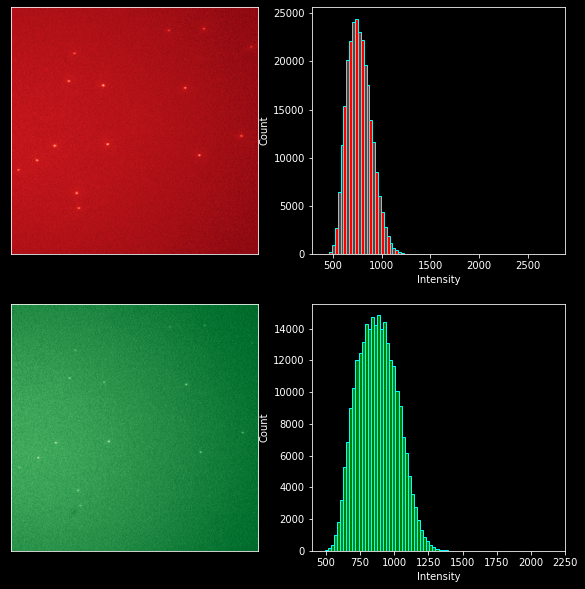

In [19]:
# Visualizing images with beads
print('The dimensions in the image with beads are: ', image_with_beads.shape, '\n')
# Visualizing the beads
fig, ax = plt.subplots(2,2, figsize=(10, 10))
ax[0,0].imshow(image_with_beads[0,:,:],cmap=plt.cm.Reds_r)
ax[0,0].set_xticks([]); ax[0,0].set_yticks([])
ax[0,1].hist(image_with_beads[0,:,:].flatten(), bins=80,color='red', ec="cyan")
ax[0,1].set_xlabel('Intensity'); ax[0,1].set_ylabel('Count')
ax[1,0].imshow(image_with_beads[1,:,:],cmap=plt.cm.Greens_r)
ax[1,0].set_xticks([]); ax[1,0].set_yticks([])
ax[1,1].hist(image_with_beads[1,:,:].flatten(), bins=80,color='green', ec="cyan")
ax[1,1].set_xlabel('Intensity'); ax[1,1].set_ylabel('Count')
ax[1,1].set_xlim(xmin=400, xmax = 2250)

plt.show()

sum of dist  2.3202932424591696
Calculating the homography matrix between the two images.
_______ 
 # Spots in first image :  13   # Spots in second image :  13 

Spots detected in the first image: 
[[398.   46.2]
 [131.   97.1]
 [119.  154.7]
 [190.  163.2]
 [359.1 168.8]]
Spots detected in the second image:
[[399.8  45.2]
 [132.1  96.9]
 [120.8 154.2]
 [191.8 163. ]
 [361.2 167.8]]
_______ 

Calculated homography matrix: 
<ProjectiveTransform(matrix=
    [[ 1.00354365e+00,  4.50075442e-03,  4.49581405e-01],
     [-2.49683225e-03,  1.00305837e+00, -3.04384351e-01],
     [ 3.38112883e-06, -2.49053105e-06,  1.00000000e+00]])>


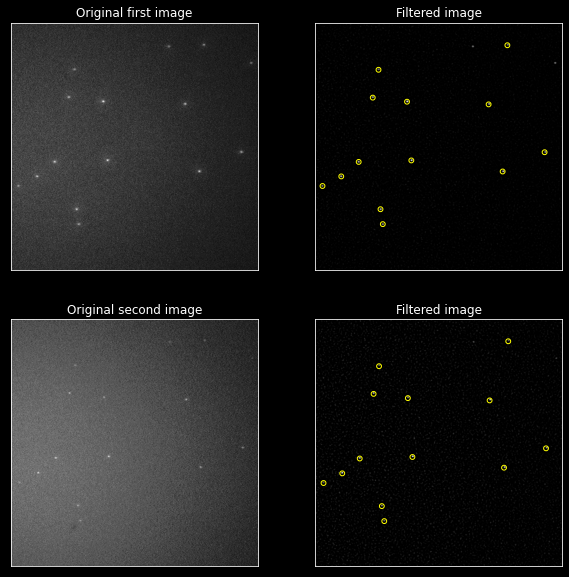

In [6]:
# Calculating the homography matrix
homography_matrix = rsp.BeadsAlignment(first_image_beads= image_with_beads[0,:,:] ,second_image_beads = image_with_beads[1,:,:], spot_size = 5, min_intensity = 400).make_beads_alignment()

In [7]:
original_video = np.expand_dims(image_with_beads, axis=0) #[0,:,:]
original_video = np.moveaxis(original_video,1,-1)
print(original_video.shape)
transformed_video_beads = rsp.CamerasAlignment(original_video, homography_matrix, target_channels= [1]).make_video_alignment()

(1, 512, 512, 2)


## Plotting original video

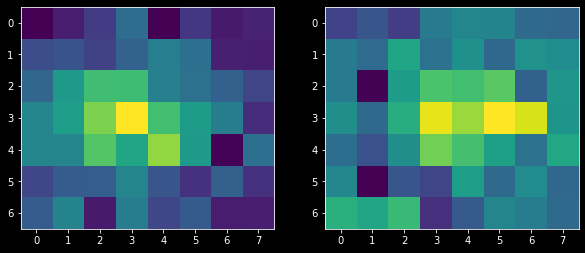

In [13]:
fig, ax = plt.subplots(1,2, figsize=(10, 5))
ax[0].imshow(original_video[0,94:101,128:136,0])
ax[1].imshow(original_video[0,94:101,128:136,1]);


## Plotting transformed video

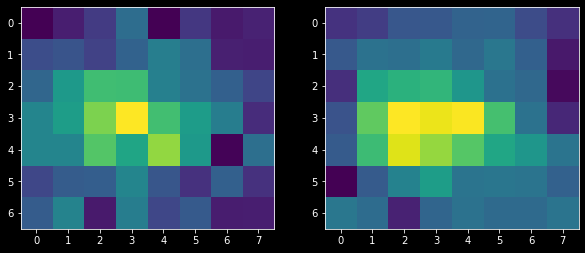

In [14]:
fig, ax = plt.subplots(1,2, figsize=(10, 5))
ax[0].imshow(transformed_video_beads[0,94:101,128:136,0])
ax[1].imshow(transformed_video_beads[0,94:101,128:136,1])

The dimensions in the image with beads are:  (1, 512, 512, 2) 



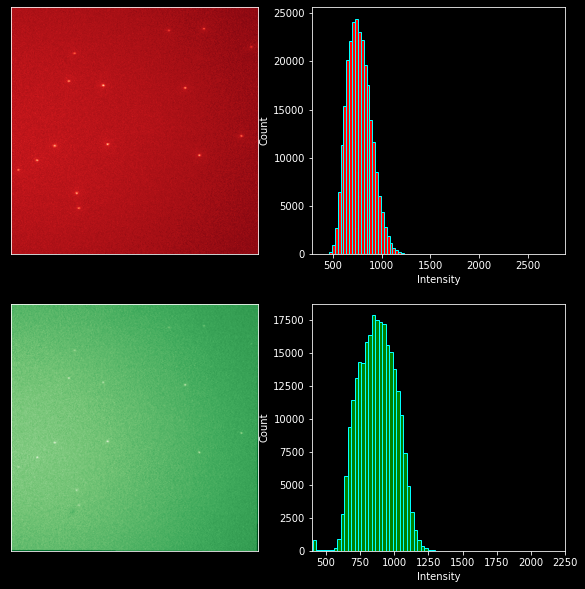

In [22]:
# Visualizing images with beads
print('The dimensions in the image with beads are: ', transformed_video_beads.shape, '\n')
# Visualizing the beads
fig, ax = plt.subplots(2,2, figsize=(10, 10))
ax[0,0].imshow(transformed_video_beads[0,:,:,0],cmap=plt.cm.Reds_r)
ax[0,0].set_xticks([]); ax[0,0].set_yticks([])
ax[0,1].hist(transformed_video_beads[0,:,:,0].flatten(), bins=80,color='red', ec="cyan")
ax[0,1].set_xlabel('Intensity'); ax[0,1].set_ylabel('Count')
ax[1,0].imshow(transformed_video_beads[0,:,:,1],cmap=plt.cm.Greens_r)
ax[1,0].set_xticks([]); ax[1,0].set_yticks([])
ax[1,1].hist(transformed_video_beads[0,:,:,1].flatten(), bins=80,color='green', ec="cyan")
ax[1,1].set_xlabel('Intensity'); ax[1,1].set_ylabel('Count')
ax[1,1].set_xlim(xmin=400, xmax = 2250)
plt.show()

The dimensions in the video are:  (5, 512, 512, 3) 



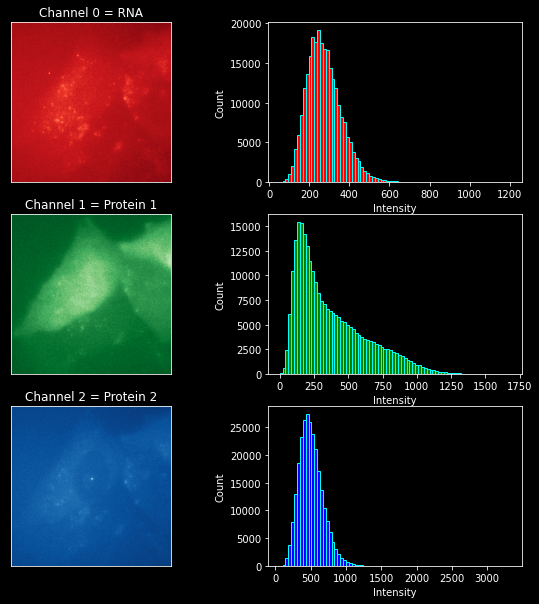

In [10]:
# Loading images with the cells
print('The dimensions in the video are: ', video.shape, '\n')
# Plotting the beads
selected_time_point = 0
fig, ax = plt.subplots(3,2, figsize=(10, 10))
ax[0,0].imshow(video[selected_time_point,:,:,0],cmap=plt.cm.Reds_r)
ax[0,0].set_title('Channel 0 = RNA');ax[0,0].set_xticks([]); ax[0,0].set_yticks([])
ax[0,1].hist(video[selected_time_point,:,:,0].flatten(), bins=80,color='red', ec="cyan")
ax[0,1].set_xlabel('Intensity'); ax[0,1].set_ylabel('Count')
ax[1,0].imshow(video[selected_time_point,:,:,1],cmap=plt.cm.Greens_r)
ax[1,0].set_title('Channel 1 = Protein 1'); ax[1,0].set_xticks([]); ax[1,0].set_yticks([])
ax[1,1].hist(video[selected_time_point,:,:,1].flatten(), bins=80,color='green', ec="cyan")
ax[1,1].set_xlabel('Intensity'); ax[1,1].set_ylabel('Count')
ax[2,0].imshow(video[selected_time_point,:,:,2],cmap=plt.cm.Blues_r)
ax[2,0].set_title('Channel 2 = Protein 2'); ax[2,0].set_xticks([]); ax[2,0].set_yticks([])
ax[2,1].hist(video[selected_time_point,:,:,2].flatten(), bins=80,color='blue', ec="cyan")
ax[2,1].set_xlabel('Intensity'); ax[2,1].set_ylabel('Count')
plt.show()

In [11]:
# Applying the alignment transformation to the whole video. Matrix multiplication to align the images from the two cameras.
transformed_video = rsp.CamerasAlignment(video, homography_matrix, target_channels= [1,2]).make_video_alignment()

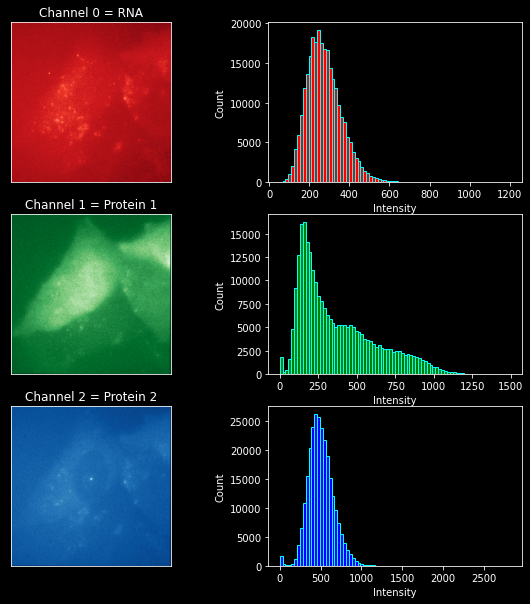

In [12]:
# Plotting the beads
selected_time_point = 0
fig, ax = plt.subplots(3,2, figsize=(10, 10))
ax[0,0].imshow(transformed_video[selected_time_point,:,:,0],cmap=plt.cm.Reds_r)
ax[0,0].set_title('Channel 0 = RNA');ax[0,0].set_xticks([]); ax[0,0].set_yticks([])
ax[0,1].hist(transformed_video[selected_time_point,:,:,0].flatten(), bins=80,color='red', ec="cyan")
ax[0,1].set_xlabel('Intensity'); ax[0,1].set_ylabel('Count')
ax[1,0].imshow(transformed_video[selected_time_point,:,:,1],cmap=plt.cm.Greens_r)
ax[1,0].set_title('Channel 1 = Protein 1'); ax[1,0].set_xticks([]); ax[1,0].set_yticks([])
ax[1,1].hist(transformed_video[selected_time_point,:,:,1].flatten(), bins=80,color='green', ec="cyan")
ax[1,1].set_xlabel('Intensity'); ax[1,1].set_ylabel('Count')
ax[2,0].imshow(transformed_video[selected_time_point,:,:,2],cmap=plt.cm.Blues_r)
ax[2,0].set_title('Channel 2 = Protein 2'); ax[2,0].set_xticks([]); ax[2,0].set_yticks([])
ax[2,1].hist(transformed_video[selected_time_point,:,:,2].flatten(), bins=80,color='blue', ec="cyan")
ax[2,1].set_xlabel('Intensity'); ax[2,1].set_ylabel('Count')
plt.show()